# Using regionprops_3d to analyze properties of each pore
The ``regionprops`` function included in *Scikit-image* is pretty thorough, and the recent version of *Scikit-image* (>0.14) vastly increase support for 3D images.  Nonetheless, there are still a handful of features and properties that are useful for porous media analysis.  The ``regionprops_3d`` in *PoreSpy* aims to address thsi need, and it's use is illustrated here.

In [1]:
import porespy as ps
import scipy.ndimage as spim
import matplotlib.pyplot as plt
%matplotlib inline

## Generating a test image
Start by generating a test image using the ``generators`` module in *PoreSpy*.

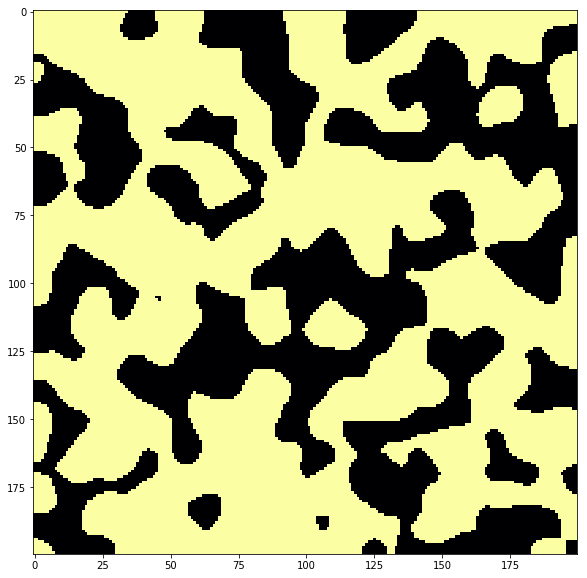

In [2]:
im = ps.generators.blobs(shape=[200, 200], porosity=0.6, blobiness=1)
plt.subplots(1, 1, figsize=(10, 10))
fig = plt.imshow(im, cmap=plt.cm.inferno)

## Segementing void space into regions for individual analysis
Next, we need to segment the image into discrete pores, which will become the *regions* that we analyze.  For this purpose we'll use the SNOW algorithm, which helps to find true local maximums in the distance transform that are used as markers in the *watershed* segementation.

In [3]:
snow = ps.network_extraction.snow(im=im)
regions = snow.regions*snow.im

____________________________________________________________
Beginning SNOW Algorithm
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  64
Peaks after trimming saddle points:  57
Peaks after trimming nearby peaks:  57
____________________________________________________________
Partitioning Pore Space using Marker Based Watershed


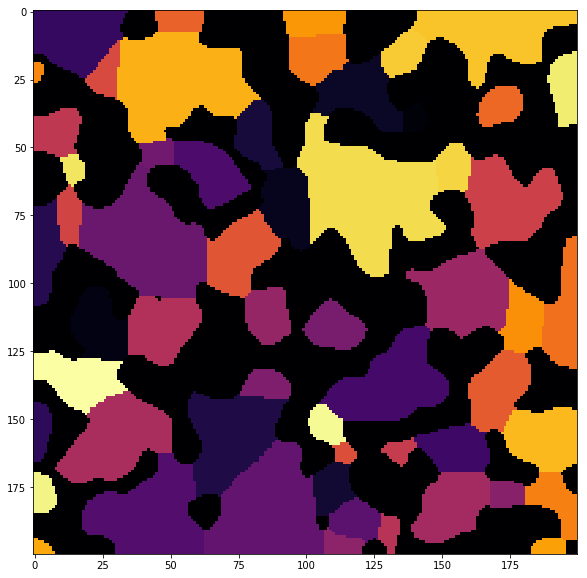

In [4]:
plt.subplots(1, 1, figsize=(10, 10))
fig = plt.imshow(regions, cmap=plt.cm.inferno)

## Applying regionsprops_3d
Now that the void space has been segmented into discrete regions, it's possible to extract information about each region using ``regionsprops_3d``.  

> **NOTE**: *PoreSpy* calls the *Scikit-image* ``regionprops`` function internally, and uses many of it's values in subsequent calculations.  The result return by ``regionprops_3d`` is the same as ``regionprops`` of *Scikit-image*, but with additional information added to each region.

In [5]:
props = ps.metrics.regionprops_3D(regions)

____________________________________________________________
Calculating regionprops


100%|██████████| 57/57 [00:00<00:00, 67.72it/s]


> **NOTE:** The ``regionprops_3d`` function in *PoreSpy* is compatible with the ``regionsprops`` function in *Scikit-image*, which returns the results in a somewhat confusing format.  An object is created for each region, and the properites of that region can be accessed as attributes of the object (e.g. ``obj[10].area``).  This makes it somewhat annoying, since all the ``area`` values cannot be accessed as a single array (*PoreSpy* has a function to address this, described below), but there is another larger *gotcha*:  Each of the region objects are collected in a list like ``[obj1, obj2, ...]``, **BUT** all regions labelled with 0 are ignored (which is solid phase in this example), so the object located in position 0 of the list corresponds to region 1.  Hence, users must be careful to index into the list correctly.

## Listing all available properties
Let's look at some of the properties for the regions, starting by printing a list of all available properties for a given region:

In [6]:
r = props[0]
attrs = [a for a in r.__dir__() if not a.startswith('_')]
print(attrs)

['label', 'slice', 'volume', 'bbox_volume', 'border', 'inscribed_sphere', 'surface_mesh_vertices', 'surface_mesh_simplices', 'surface_area', 'sphericity', 'skeleton', 'convex_volume', 'graph', 'area', 'bbox', 'bbox_area', 'centroid', 'convex_area', 'convex_image', 'coords', 'eccentricity', 'equivalent_diameter', 'euler_number', 'extent', 'filled_area', 'filled_image', 'image', 'inertia_tensor', 'inertia_tensor_eigvals', 'intensity_image', 'local_centroid', 'max_intensity', 'mean_intensity', 'min_intensity', 'major_axis_length', 'minor_axis_length', 'moments', 'moments_central', 'moments_hu', 'moments_normalized', 'orientation', 'perimeter', 'solidity', 'weighted_centroid', 'weighted_local_centroid', 'weighted_moments', 'weighted_moments_central', 'weighted_moments_hu', 'weighted_moments_normalized']


*Scikit-image* utilization a trick called *lazy evaluation* which means that it does not actually calculate many of the properties in the above list until it is asked for.  This is obviously useful since it means the user doesn't have to wait for everything to be calculated when they only want one property, but this leads to two issues:

1.  It means that some of the above properties aren't actually available.  For instance, if the ``intensity_image`` is requested an error will be thrown since we didn't not specify one when we called ``regionprops``.  

2.  Inside the ``regionprops_3d`` function, some of the properties calculated by ``regionsprops`` are called and used.  This means that ``regionprops_3d`` appears to be much slower, but this is just because it is waiting for the deferred execution of results from ``regionprops``.  

## Analyze properties for a single region
Now let's look at some of the properties for each region:

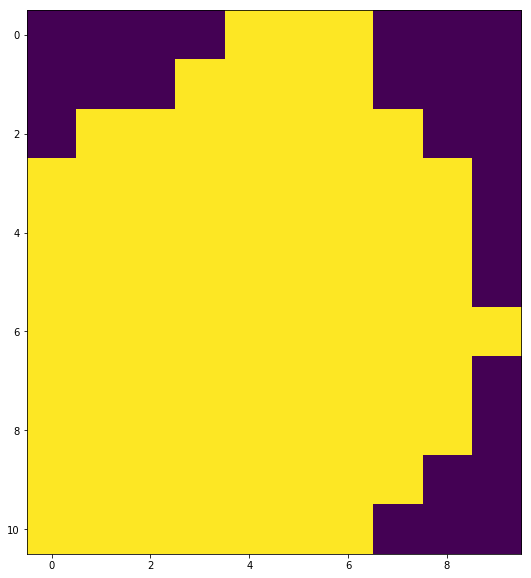

In [7]:
# View am image of the region in isolation
plt.subplots(1, 1, figsize=(10, 10))
plt.imshow(r.image)

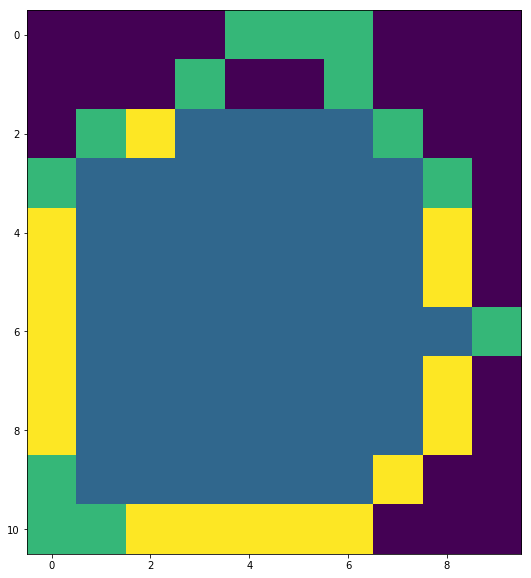

In [8]:
# View image of region's border and largest incribed sphere together
plt.subplots(1, 1, figsize=(10, 10))
plt.imshow(r.border + 0.5*r.inscribed_sphere)

One of the most useful properties is the convex image, which is an image of the region with all the depressions in the boundary filled in.  This is useful because one can compare it to the actual region and learn about the shape of the region.  One such metric is the *solidity*.

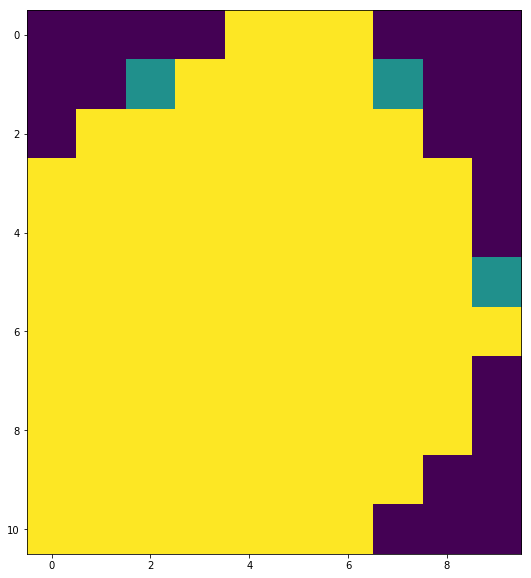

In [9]:
plt.subplots(1, 1, figsize=(10, 10))
fig = plt.imshow(r.image + 1.0*r.convex_image)

In [10]:
print(r.solidity)

0.9655172413793104


## Extracting one property for all regions as an array

As mentioned above, the *list* of objects that is returned by the ``regionprops_3d`` funciton is a bit inconvientient for access one piece of information for all regions at once.  *PoreSpy* has a function called ``props_to_DataFrame`` which helps in this regard by generating a Pandas DataFrame object with all of the *key metrics* listed as Numpy arrays in each column.  *Key metrics* refers to scalar values like area and solidity.

In [11]:
df = ps.metrics.props_to_DataFrame(props)
print(df.keys())

C:\Users\Jeff\Anaconda3\lib\site-packages\skimage\measure\_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
C:\Users\Jeff\Anaconda3\lib\site-packages\skimage\measure\_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


Index(['area', 'bbox_area', 'bbox_volume', 'convex_area', 'convex_volume',
       'eccentricity', 'equivalent_diameter', 'euler_number', 'extent',
       'filled_area', 'label', 'major_axis_length', 'minor_axis_length',
       'orientation', 'perimeter', 'solidity', 'sphericity', 'surface_area',
       'volume'],
      dtype='object')


As can be seen above, there are fewer items in this DataFrame than on the regionprops objects.  This is because only scalar values are kept (e.g. images are ignored), and some of the metrics were not valid (e.g. intensity_image).

With this DataFrame in hand, we can now look a histograms of various properties:

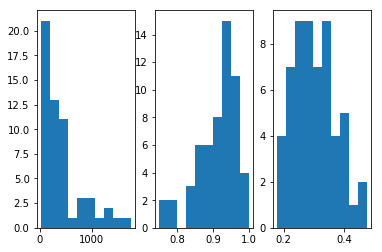

In [12]:
plt.subplot(1, 3, 1)
fig = plt.hist(df['volume'])
plt.subplot(1, 3, 2)
fig = plt.hist(df['solidity'])
plt.subplot(1, 3, 3)
fig = plt.hist(df['sphericity'])

Another useful feature of the Pandas DataFrame is the ability to look at all metrics for a given pore at once, which is done by looking at a single row in all columns:

In [13]:
df.iloc[0]

area                    84.000000
bbox_area              110.000000
bbox_volume            110.000000
convex_area             87.000000
convex_volume           87.000000
eccentricity             0.548023
equivalent_diameter     10.341766
euler_number             1.000000
extent                   0.763636
filled_area             84.000000
label                    1.000000
major_axis_length       11.391681
minor_axis_length        9.528719
orientation              1.204069
perimeter               32.727922
solidity                 0.965517
sphericity               0.400369
surface_area           231.673645
volume                  84.000000
Name: 0, dtype: float64

## Creating a composite image of region images
Another useful function available in *PoreSpy* is ``props_to_image``, which can create an image from the various subimages available on each region.

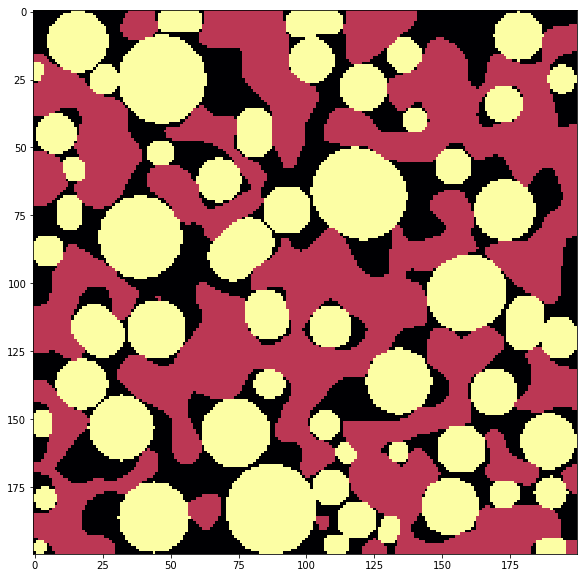

In [14]:
# Create an image of maximally inscribed spheres
sph = ps.metrics.props_to_image(regionprops=props, shape=im.shape, prop='inscribed_sphere')
plt.subplots(1, 1, figsize=(10, 10))
fig = plt.imshow(sph + 0.5*(~im) , cmap=plt.cm.inferno)

## Creating a colorized image based on region properties
The ``props_to_image`` function can also accept a scalar property which will result in an image of the regions colorized according to the local value of that property.

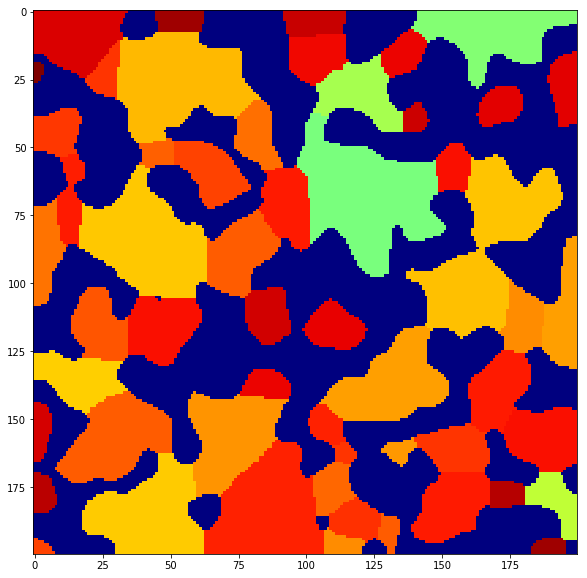

In [15]:
# Create an image colorized by solidity
sph = ps.metrics.props_to_image(regionprops=props, shape=im.shape, prop='solidity')
plt.subplots(1, 1, figsize=(10, 10))
fig = plt.imshow(sph + 0.5*(~im) , cmap=plt.cm.jet)

Clearly the regions that have few inlets in their bounary are darker red, because they are more *solid*.